Рассмотрим задачу о намерзании льда на поверхности водоёма глубиной $1$ метр, который в начальный момент времени находится полностью в жидком состоянии.

Для этого решим уравнение теплопроводности, при учёте фазового перехода в среде, считая, что плотность среды $\rho$ не изменяется при фазовом перходе.

$$\begin{cases}
    \rho c_s \frac{\partial T}{\partial t} = a_s \frac{\partial^2 T}{\partial x^2}, \; 0 < x < y(t) \\
    \rho c_f \frac{\partial T}{\partial t} = a_f \frac{\partial^2 T}{\partial x^2}, \; y(t) < x < 1 \\
    T(y(t), t) = T_p
\end{cases}$$

Здесь $y(t)$ - граница раздела фаз, $T(x, t)$ - распределние температуры, $T_p = 273 \text{К}$ - температура плавления льда.

Также необходимо учесть условие баланса энергии при движении фазового фронта:

$$a_s \frac{\partial T}{\partial x}(y(t) - 0, t) - a_f \frac{\partial T}{\partial x}(y(t) + 0, t) = \rho L \frac{\mathrm{d} y}{\mathrm{d} t}$$

Это уравнение будем использовать для определения положения границы раздела вместо $T(y(t), t) = T_p$.

В качестве начально-краевых условий возмём:

$T(x, 0) = \varphi(x) = \left( 7x + 273 \right) \text{К}$

$T(0, t) = \Psi_l(t) = [273 - 13(1 - e^{-10t})] \text{К}$ - поверхность водоёма

$T(1, t) = \Psi_r(t) =  280 \text{К}$ - дно водоёма

Схема Лакса-Вендроффа

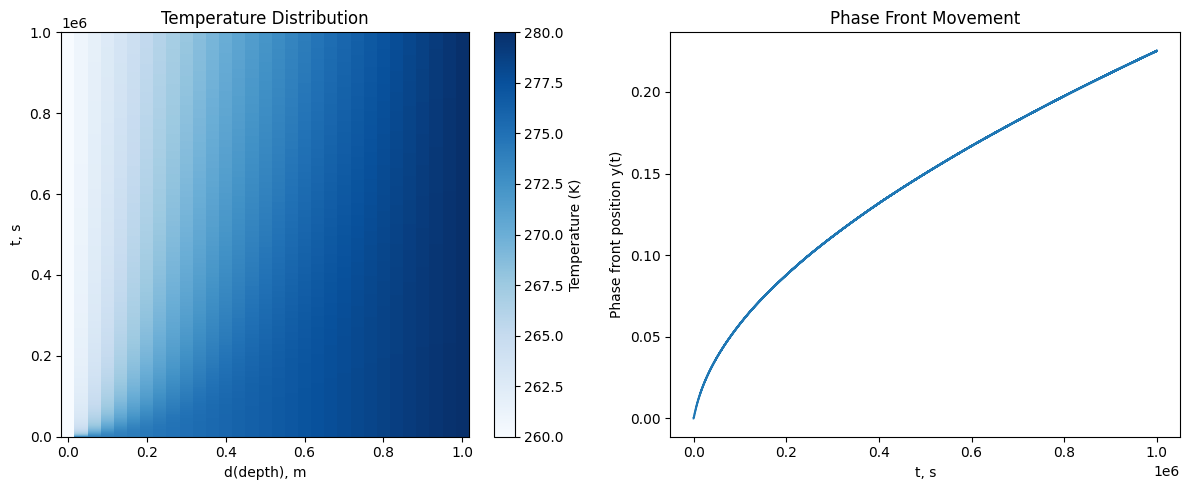

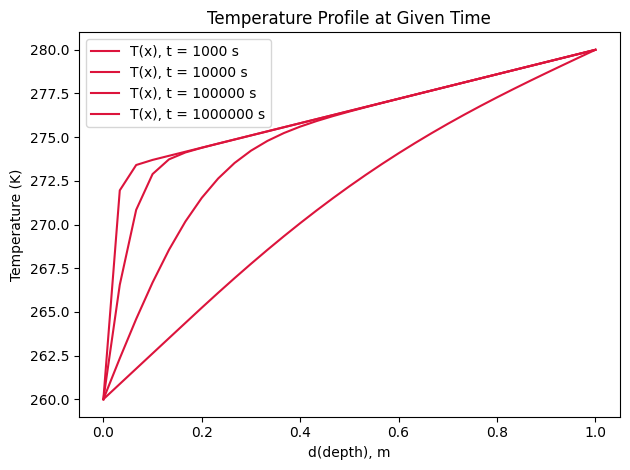

In [ ]:
from PDElib import * # HESolver(methods for solving heat equations), Grid
from math import *

@dataclass
class HEParams:
    rho : float # density
    T_p : float # phase change temperature
    L : float # heat of fusion
    # fluid:
    c_f : float # heat capacity
    a_f : float # thermal conductivity
    #solid:
    c_s : float # heat capacity
    a_s : float # thermal conductivity

# Heat Equation Solver
# solve rho*c*T't = a*T''x = 0
# c = c_s if x < y(t) else c = c_f
# a = a_s if x < y(t) else a = a_f
# y(t) defined by rule T(y(t), t) = T_p
# WARNING: The temperature should increase monotonically from left to right!
# takes into account the balance of energies:
# a_s*T'x(y(t) - 0) - a_f*T'x(y(t) + 0) = rho*L*y't
# T(x, 0) = phi(1)
# T(0, t) = psi_l(t)
# T(grid.L, t) = psi_r(t)
# returns (y[t], T[t][x])
class HESolver:
    @staticmethod
    def __prepare(grid : Grid, phi : RtoR, psi_l : RtoR, psi_r : RtoR):
        tau = grid.T / grid.N
        h = grid.L / grid.M
        u = [[phi(m*h) for m in range(grid.M + 1)]]
        for n in range(1, grid.N + 1):
            u += [[psi_l(tau*n)] + [0 for _ in range(grid.M - 1)] + [psi_r(tau*n)]]
        return tau, h, u

    # predicts next position of phase front with second order
    @staticmethod
    def __predict_phase_front(params : HEParams, grid: Grid, T : list[float], y : list[float]):
        yp = 0 if len(y) < 2 else y[-2] # y_{n-1}
        h = grid.L / grid.M
        m = min(max(int(y[-1] / h), 1), grid.M - 2)
        f = (params.a_s * (T[m+1] - T[m-1]) - params.a_f * (T[m+2] - T[m])) / (2*h)
        return 2*grid.T/grid.N*f/(params.rho*params.L) + yp

    @staticmethod
    def __solve_explicit(params : HEParams, grid: Grid, phi: RtoR, psi_l: RtoR, psi_r: RtoR, __scheme):
        tau, h, u = HESolver.__prepare(grid, phi, psi_l, psi_r)
        k_s = params.a_s / (params.rho * params.c_s) * tau/h/h
        k_f = params.a_f / (params.rho * params.c_f) * tau/h/h
        y = [0]
        for n in range(grid.N):
            y += [HESolver.__predict_phase_front(params, grid, u[n], y)]
            boundary = min(max(int(y[-1] / h), 1), grid.M)
            for m in range(1, boundary):
                u[n+1][m] = __scheme(k_s, u, n, m)
            for m in range(boundary, grid.M):
                u[n+1][m] = __scheme(k_f, u, n, m)
        return y, u

    @staticmethod
    def solve_by_Lax_Wendroff_scheme(params : HEParams, grid: Grid, phi: RtoR, psi_l: RtoR, psi_r: RtoR):
        scheme = lambda k, u, n, m: u[n][m] + k * (u[n][m+1] - 2*u[n][m] + u[n][m-1])
        return HESolver.__solve_explicit(params, grid, phi, psi_l, psi_r, scheme)
    
phi = lambda x: 7*x + 273
psi_l = lambda t: 273 - 13*(1 - exp(-t/10))
psi_r = lambda t: 280

grid = Grid(1e6, 10000, 1, 30)
params = HEParams(rho=1000, T_p=273, L=3.3e5, c_f=4200, a_f=0.56, c_s=2100, a_s=2.25)

import matplotlib.pyplot as plt
import numpy as np

def plot_temperature_and_phase_front(y, T, grid):
    # Create a meshgrid for time and space
    time_points = np.linspace(0, grid.T, grid.N + 1)
    space_points = np.linspace(0, grid.L, grid.M + 1)
    T_array = np.array(T)

    # Temperature distribution heatmap
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.pcolormesh(space_points, time_points, T, cmap="Blues")
    #plt.imshow(T_array, extent=[0, grid.L, grid.T, 0], aspect='auto', cmap='hot')
    plt.colorbar(label='Temperature (K)')
    plt.xlabel("d(depth), m")
    plt.ylabel("t, s")
    plt.title('Temperature Distribution')

    # Phase front position
    plt.subplot(1, 2, 2)
    plt.plot(time_points, y[:grid.N + 1])
    plt.xlabel("t, s")
    plt.ylabel('Phase front position y(t)')
    plt.title('Phase Front Movement')

    plt.tight_layout()
    plt.show()

# Call the plotting function with your simulation results
y, T = HESolver.solve_by_Lax_Wendroff_scheme(params, grid, phi, psi_l, psi_r)
plot_temperature_and_phase_front(y, T, grid)

def plot_temperature_profile_at_time(T, grid, t_query):
    # Проверка времени
    if not (0 <= t_query <= grid.T):
        raise ValueError(f"t_query должно быть в диапазоне от 0 до {grid.T}")

    # Индекс временного слоя, ближайшего к t_query
    time_index = int(t_query / grid.T * grid.N)
    
    # Координаты по пространству
    space_points = np.linspace(0, grid.L, grid.M + 1)

    # Извлекаем профиль температуры
    T_profile = T[time_index]

    # Построение графика
    plt.plot(space_points, T_profile, label=f"T(x), t = {t_query:.0f} s")
    plt.xlabel("d(depth), m")
    plt.ylabel("Temperature (K)")
    plt.title("Temperature Profile at Given Time")

plot_temperature_profile_at_time(T, grid, 1e3)
plot_temperature_profile_at_time(T, grid, 1e4)
plot_temperature_profile_at_time(T, grid, 1e5)
plot_temperature_profile_at_time(T, grid, 1e6)
plt.tight_layout()
plt.legend()